# Coastal Systems Notebook 2d: Tidal Constituents

In Chapter 3 of the book and slides, we learned that the tide is generated through the interplay between gravitational attraction forces in the Earth-Moon and Earth-Sun systems respectively. In this notebook we will explore these concepts in a more interactive way, with some exercises, visualizations, and code. We will not repeat the whole theory, however, so make sure you have followed the lectures for this week and read the relevant pages in chapter 3 of the book.

Earth has continents, oceans with varying water depths, and a complex gravitational field, hence the tidal signals we observe around the planet are complex. Fortunately, we can break them down into multiple harmonic components, called ***tidal constituents***. These can either be diurnal, semi-diurnal, short-, or long-period constituents. Each constituent is characterized by an amplitude, frequency and phase, and individually looks like a smooth sin/cosine curve. When we sum up all the individual components we observe signal beating resulting in complex tidal signals with spring-neap cycles, daily inequalities, and longer-term variations.

A table of principal tidal constituents is provided below (compare Table 3.5 in the book). These components are direclty related to the astronomical forcing and the listed amplitudes are according to equilibrium theory. The period is given with more significant figures than in Table 3.5 to make more accurate calculations of the beating periods possible.

|Tidal constituents | Name | Equil. <br> Amplitude [m] | Period [h] |
|-|-|-|-|
| **Semi-diurnal** |
| Principal lunar | M2 | 0.24 | 12.4206012 |
| Principal solar | S2 | 0.11 | 12 |
| Lunar elliptical | N2 | 0.046 | 12.65834751 |
| Lunar-solar declinational | K2 | 0.031 | 11.96723606 |
| **Diurnal** |
| Lunar-solar declinational | K1 | 0.14 | 23.93447213 |
| Principal lunar | O1 | 0.10 | 25.81933871 | 
| Principal solar | P1 | 0.047 | 24.06588766 | 
| Lunar elliptical | Q1 | 0.019 | 26.868350 |
| **Long period** |
| Fortnightly | Mf | 0.042 | 327.8599387 |
| Monthly | Mm | 0.022 | 661.3111655 | 
| Semi-annual | Ssa | 0.019 | 4383.076325 | 

<br><br>

In [1]:
# Run this to import modules

import pathlib
from pathlib import Path
import sys
from warnings import filterwarnings
import ipywidgets as widgets
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from datetime import datetime, timedelta
from IPython.display import display, Image
import math
from ipywidgets import interact
import pooch
import uptide
import pickle

from Tide_Initialize import plot_timeseries_with_interactive_controls, questions_2d


cwd = pathlib.Path().resolve()
proj_dir = cwd.parent  # this is the root of the CoastalCodeBook
DATA_DIR = proj_dir / "data"


<br> <br>
## Visualisation of Astronomical Constituents

In this part of the exercise, our aim is to enhance the understanding of tidal constituents by visualising the full observational sea level in comparison to the tidal signal at Scheveningen. To achieve this, we will use two datasets:
- [GESLA-3 (Global Extreme Sea Level Analysis)](https://gesla787883612.wordpress.com/) sea level records
- [FES2014 Global Tide data](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/description-fes2014.html), providing amplitude and phase information for 34 tidal constituents, distributed on 1/16˚ grids.


<br> Look at the cell below and run it to see how the observed sea level matches up with the tidal signal derived from the available 34 constituents. The tidal constituents include both astronomical constituents (like in the Table above) and non-linear shallow-water tides or overtides. These tidal signals were computed for an arbitrary timeframe spanning from 1977 to 2017, using the [uptide](https://github.com/stephankramer/uptide) python package.

Can you try to explain why the tidal signal doesn't perfectly match the observed sea level?

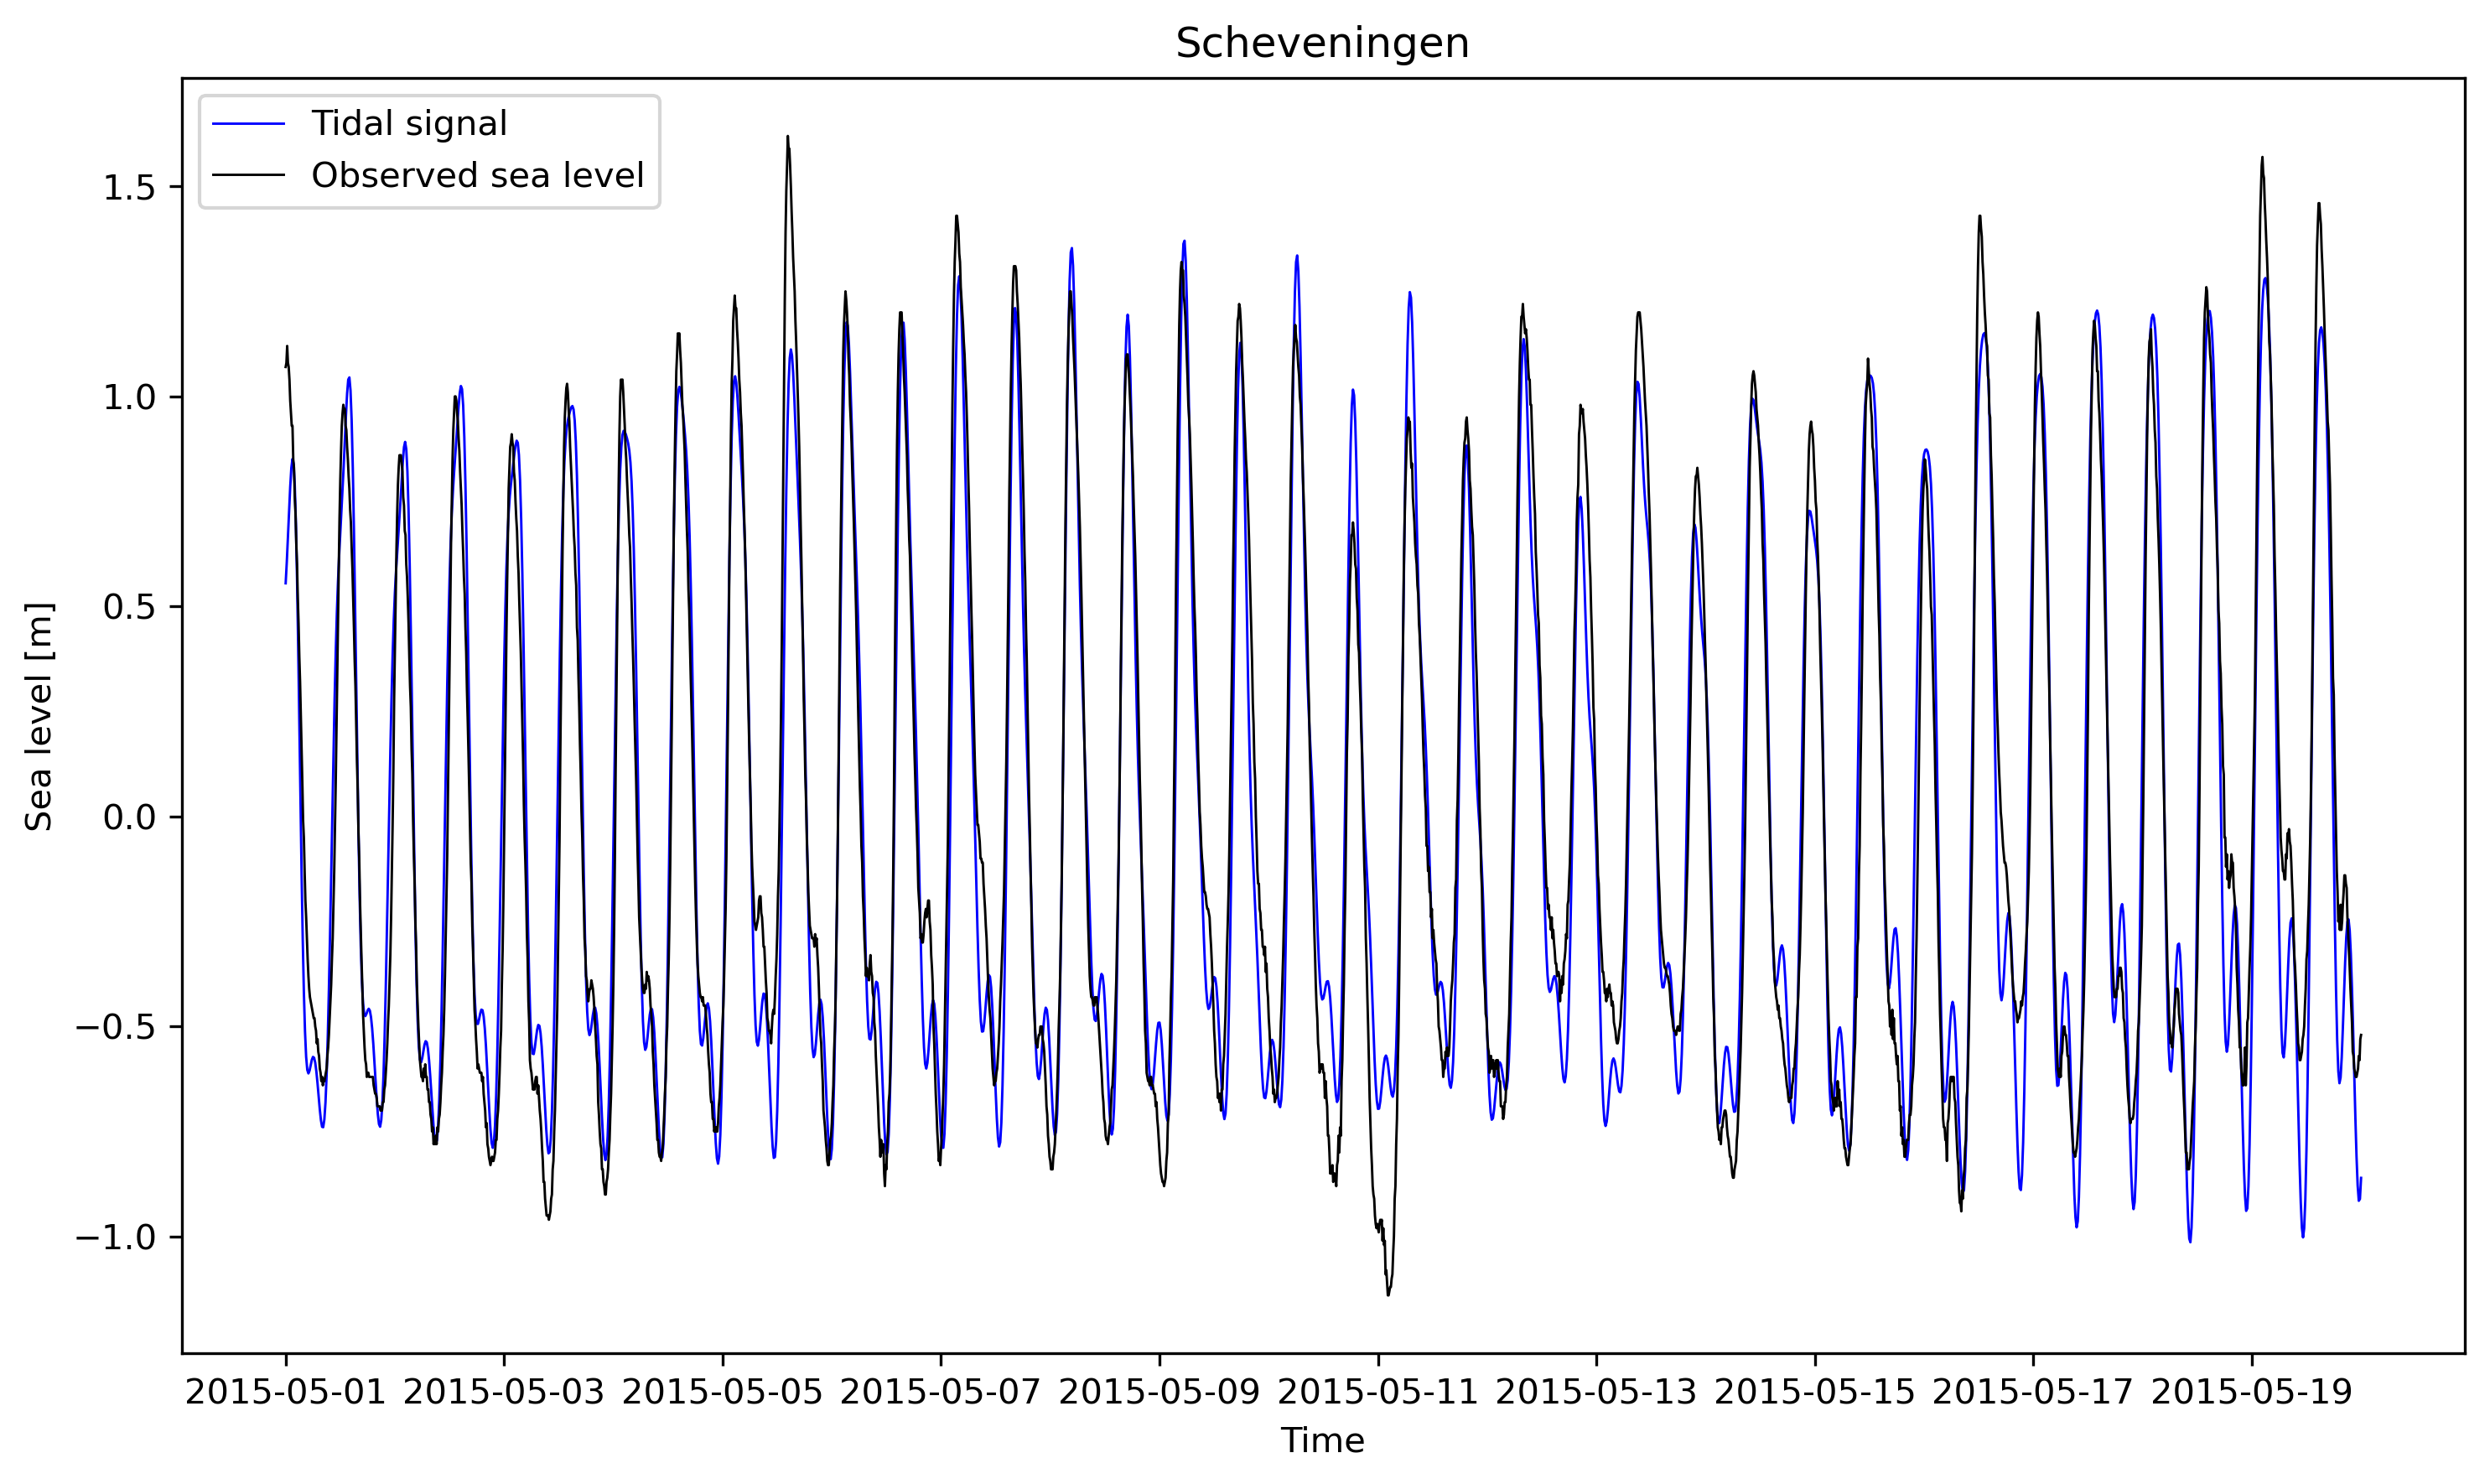

In [2]:
## Download GESLA tide gauge data for Scheveningen

tide_gauge_fp = pooch.retrieve(
    "https://coclico.blob.core.windows.net/coastal-dynamics/2_wind_waves_tides/Scheveningen_GESLA.pkl",
    known_hash="90355584803ddcdf88b01fcf02546c4d8201a3fa6f63355ecfdb8ab6a07d1e38",
)
tide_gauge = pd.read_pickle(tide_gauge_fp)

## Load FES2014 amplitude and phase data and calculate the signal
# see the commented script at the bottom of the notebook if you want to know how to load FES2014 amplitude and phase data

tide = {}; amplitudes = {}; phases = {}
comps = ['EPS2', 'J1', 'K1', 'K2', 'L2', 'LAMBDA2', 'M2', 'M3', 'M4', 'M6', 'M8', 'MF', 'MKS2',
         'MM', 'MN4', 'MS4', 'MSF', 'MSQM', 'MTM', 'MU2', 'N2', 'N4', 'NU2', 'O1', 'P1', 'Q1',
         'R2', 'S1', 'S2', 'S4', 'SA', 'SSA', 'T2']

for comp in comps:
    fp = proj_dir / "radno/fes2014_amp_ph" / ("02_" + comp.lower() + ".p")
    # fp = DATA_DIR / "fes2014_amp_ph" / ("02_" + comp.lower() + ".p")
    tide[comp.lower()] = pd.read_pickle(fp)
    amplitudes[comp.lower()] = tide[comp.lower()]['amplitude']['scheveningen']
    phases[comp.lower()] = tide[comp.lower()]['phase']['scheveningen']

# Choose th initial time for calculating the tidal signel (has to be between 1977-2017)
initial_time = datetime(1977, 1, 1, 12, 0, 0)

tidal_signal = uptide.Tides(comps)  # select which constituents to use, we will use all
tidal_signal.set_initial_time(initial_time)  # set t=0 at 1 Jan 1977, UTC 12:00, arbitrary choice
amp = [amplitudes[comp.lower()] for comp in comps]
pha = [math.radians(phases[comp.lower()]) for comp in comps] # phase (in radians!)
t = np.arange(0, 365*40*24*3600, 900) # seconds since initial time, 40 years since 1977, 15min frequency
dates = np.array([initial_time + timedelta(seconds=int(s)) for s in t]) # so that we have datetime on x-axis
eta = tidal_signal.from_amplitude_phase(amp, pha, t) # calculate the signal
eta_df = pd.DataFrame({'eta': eta}, index=dates)

## Plot
# Choose a time window to plot (has to be between 1977 - 2017)
start_date = '2015-05-01 00:00' 
end_date = '2015-05-20 00:00'

filtered_gauge = tide_gauge[start_date:end_date]
filtered_tide = eta_df[start_date:end_date]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(filtered_tide.index, filtered_tide['eta']/100, color='blue', 
        label='Tidal signal', linewidth=0.7)
ax.plot(filtered_gauge.index, filtered_gauge, color='black', 
        label='Observed sea level', linewidth=0.7)
ax.set_xlabel('Time')
ax.set_ylabel('Sea level [m]')
ax.set_title('Scheveningen')
ax.legend()
plt.tight_layout()
plt.show()

<br><br><br>
What if we don't use all 34 tidal constituents? 
Below is an interactive plot in which you can adjust the plotted time range using the slider (from 1 day to 1 year). You can select which tidal constituents should be plotted with the tick boxes. This way you can play around with different constituents and see what kind of signal you get and how close it is to the total tidal signal.

The plot displays the individual tidal components (upper plot), their combined tidal signal (second plot), the combined tidal signal against the total tidal signal (third plot), and the observed sea level with the total tidal signal and the combined signal (fourth plot).

In [3]:
# We choose one year to plot, 2000-2001

with open('../data/02_tide_scheveningen.p', 'rb') as pickle_file:
    scheveningen = pickle.load(pickle_file)
    
plot_timeseries_with_interactive_controls(tide_gauge, eta_df, scheveningen)

# it is a bit difficult to see the other date, you can click on the text

<br><br>
Now we focus on the interplay between some of the main semi-diurnal and diurnal components. Use the interactive plot above and try to answer the questions below. Give your numeric answer with at least three significant figures.

In [40]:
## Write your code here to get the answer to the questions. Use the table of principal constituents and equation 3.24b from the textbook







In [4]:
## Run this cell to get questions

questions_2d()
# answer1: [14.765, 14.8] 
# answer2: daily inequality
# answer3: [1.075, 1.08]



1. Set the time range to around 30 days and select only the main semi-diurnal components (M2 and S2). Which phenomenon can you detect when looking at the combined signal of these two? What is the period of this beating (in days)? 




2. Now select the M2 and K1 components. Looking at the combined signal, which phenomenon can you detect this time?




3. Can you explain this phenomenon from the beating period of M2 and K1? Compute this beating period (in days).


<br><br><br>
## Tidal Amplitudes

Figure 3.27 in the textbook shows a spectrum of equilibrium tides. Let's now look at the amplitudes of the tidal constituents at Scheveningen, obtained from FES2014, in a similar way. 

- What are the main constituents?  
- What are their frequencies (compare to the periods in Table 1)?
- Can you recognize the tides near twice a day and near once a day?
- How do the diurnal and semi-diurnal constituents that we used above relate to this larger set?
- How do the longer-period constituents that we used above relate to this larger set?
- Can you recognize the non-linear shallow water tides and longer-period tides?



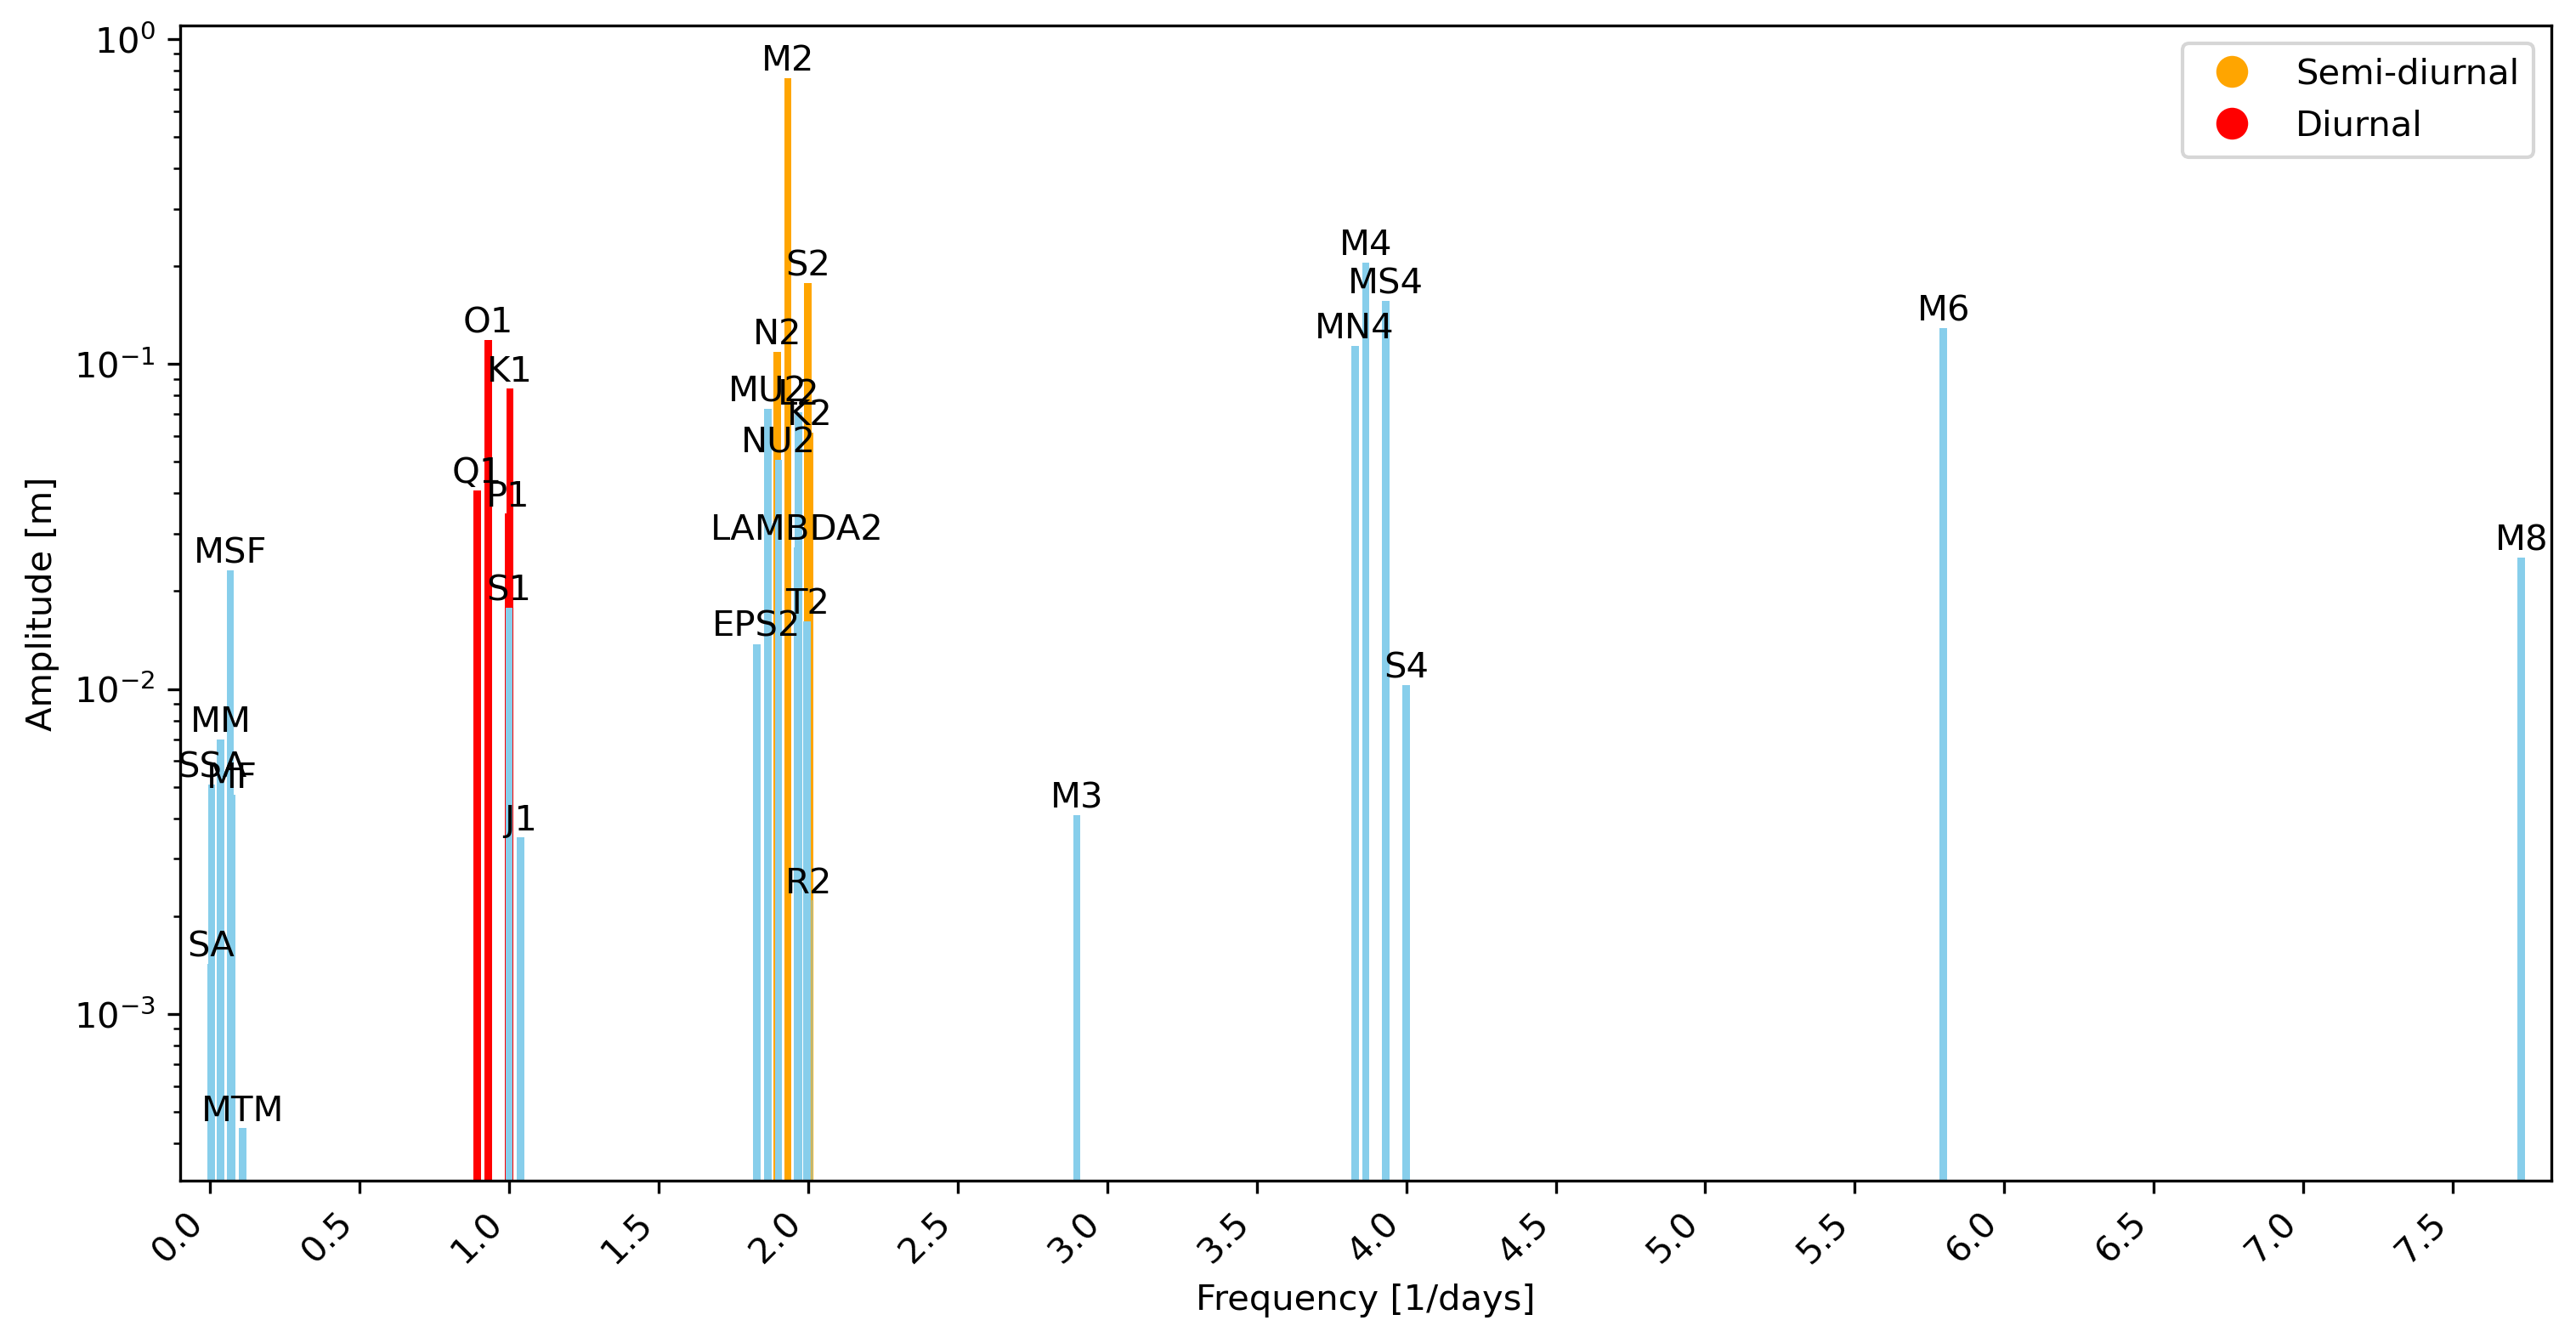

In [5]:
## Load FES2014 amplitudes
data_dir_path = Path("../data/fes2014_amp_ph/")
tide = {}; amplitudes = {};

# This time we will include more constituents:
comps = ['eps2', 'j1', 'k1', 'k2', 'l2', 'lambda2', 'm2', 'm3', 'm4', 'm6', 'm8', 'mf',
         'mm', 'mn4', 'ms4', 'msf', 'mtm', 'mu2', 'n2', 'nu2', 'o1', 'p1', 'q1',
         'r2', 's1', 's2', 's4', 'sa', 'ssa', 't2']

for comp in comps:
    fp = data_dir_path / ("02_" + comp + ".p")
    tide[comp] = pd.read_pickle(fp)
    amplitudes[comp] = tide[comp]['amplitude']['scheveningen']
    
component_names = list(amplitudes.keys())
component_names_upper = [comp.upper() for comp in component_names]  # Convert to uppercase
amplitude_values = [value / 100 for value in amplitudes.values()] 

periods = [13.13, 23.09848146, 23.93447213, 11.96723606, 12.19162085, 12.22177348, 
           12.4206012, 8.280400802, 6.210300601, 4.140200401, 3.105150301, 327.8599387, 
           661.3111655, 6.269173724, 6.103339275, 354.3670666, 219, 12.8717576, 12.65834751, 
           12.62600509 , 25.81933871, 24.06588766, 26.868350,
          11.98359564, 24, 12, 6, 8766.15265, 4383.076325, 12.01644934] # in [h]

frequency = [1 / (period/24) for period in periods] # in [1/days]

semidiurnal = ['m2', 's2', 'n2', 'k2']
diurnal = ['k1', 'o1', 'p1', 'q1']

## Bar plot
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.025  # Using a small width for better visualization

for i, freq in enumerate(frequency):
    ax.bar(freq, amplitude_values[i], color='skyblue', width=bar_width)

    # Plot semi-diurnal components in orange
    if component_names[i] in semidiurnal:
        ax.bar(freq, amplitude_values[i], color='orange', width=bar_width)

    # Plot diurnal components in red
    if component_names[i] in diurnal:
        ax.bar(freq, amplitude_values[i], color='red', width=bar_width)

    ax.text(freq, amplitude_values[i], 
                component_names[i].upper(), ha='center', va='bottom', rotation=0)

ax.set_xlabel('Frequency [1/days]')
ax.set_ylabel('Amplitude [m]')
ticks = np.arange(0, max(frequency) + 0.1, 0.5)
plt.xticks(rotation=45, ha='right', ticks=ticks)  
plt.xlim([0 - 0.1, max(frequency) + 0.1])
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Semi-diurnal'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Diurnal')
]
ax.legend(handles=legend_elements)
plt.yscale('log') # comment this line to see the differences better
plt.show()


<br><br>
Examine the M2 amplitude and phase pattern along the Atlantic as computed from the FES2014 data. What insights does this pattern provide? Can you link the amplitudes and phases to the Figure 3.30 from the textbook?

![image](../notebooks/figures/02_M2_amplitude_phase.png)

In [9]:
### Script for loading FES2014 data

# import xarray as xr
# from os.path import join
# import pandas as pd

# path = '.../ocean_tide_extrapolated/' # Your path to data

# # Rename la2 to lambda2 if you plan on using uptide
# comps = ['eps2', 'j1', 'k1', 'k2', 'l2', 'la2', 'm2', 'm3', 'm4', 'm6', 'm8', 'mf', 'mks2',
#          'mm', 'mn4', 'ms4', 'msf', 'msqm', 'mtm', 'mu2', 'n2', 'n4', 'nu2', 'o1', 'p1', 'q1',
#          'r2', 's1', 's2', 's4', 'sa', 'ssa', 't2']

# # Resolution of fes2014 is 0.0625x0.0625 (lat,lon), we choose a few 
# # locations and the closest model points

# locs = {
#     'scheveningen'  :   [52.125, 4.25], #lat, lon
#     'galveston'     :   [29.25, -94.6875],
#     'valparaiso'    :   [-33, -71.625],
#     'jakarta'       :   [-6.0625, 106.8125]
# }

# tide = {}

## Extract constituents from FES2014 and store pickle files
# for comp in comps:
#     data = xr.open_dataset(join(path, comp + '.nc'))
#     data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180 #lon=[0,360]
#     temp = {}

#     for loc in locs.keys():
#         temp[loc] = (data.sel(lat=locs[loc][0],lon=locs[loc][1])
#         .to_dataframe()
#         .drop(['lat_bnds', 'lon_bnds', 'crs'], axis=1)
#         .drop(1)
#         .assign(place=loc)
#         .set_index('place', drop=True)
#     )

#     tide[comp] = pd.concat(temp.values()) 
#     tide[comp].to_pickle('path/02_%s.p' % comp) # Choose your path
